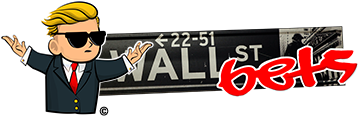

# Post popularity prediction

## Preprocessing

In [ ]:
df = pd.read_csv('with_transformed_text_atributes.csv', na_filter=False)

# remove 27th and 28th if the post wasn't popular
df_accepted = df[~(((df["day"] == 27) | (df["day"] == 28)) & (df["score"] < 100))]
df_rejected = df[(((df["day"] == 27) | (df["day"] == 28)) & (df["score"] < 100))]
print(f"Rejected: {df_rejected.shape[0]}")
print(f"Accepted: {df_accepted.shape[0]}")
df = df_accepted.append(df_rejected.sample(frac=0.1))
print(f"After reintroducing some rejects: {df.shape[0]}")

df = df.drop(["year", "day", "comms_num", "upvote_ratio"], axis=1)

df.to_csv('final_df.csv', index=False)
df.head(3) 

Rejected: 21354
Accepted: 17278
After reintroducing some rejects: 19413


score  month  hour  minute  ...  type_image  type_other  type_self  type_video
1   1157      1    23      12  ...           1           0          0           0
2      0      2     5      17  ...           0           0          1           0
6     65      2    20      17  ...           0           0          1           0

[3 rows x 164 columns]

## Preliminary models test

In [ ]:
df = pd.read_csv('final_df.csv', na_filter=False)

X = df.drop(['score'], axis=1)
y = df['score']

models = {
    'LinearRegression': LinearRegression(),
    'ElasticNet': ElasticNet(random_state=0),
    'Ridge': Ridge(random_state=0),
    'Lasso': Lasso(random_state=0),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
    'XGBRegressor': XGBRegressor(early_stopping_rounds=10),
    'CatBoostRegressor': CatBoostRegressor(loss_function='MAE', early_stopping_rounds=10),
    'RandomForestRegressor': RandomForestRegressor(random_state=0),
    'MLPRegressor': MLPRegressor(random_state=0)
}

params = {
    'ElasticNet': {'model__max_iter': [500, 1000]},
    'Ridge': {'model__max_iter': [500, 1000]},
    'Lasso': {'model__max_iter': [500, 1000]},
    'RandomForestRegressor': {'model__n_estimators': [50, 100, 200]},
    'DecisionTreeRegressor': {'model__max_depth': [None, 5, 10, 20]},
    'MLPRegressor': {'model__max_iter': [500, 1000]},
    'CatBoostRegressor': {'model__depth': [6, 8, 10], 'model__learning_rate': [.03,.06]},
    'XGBRegressor': {'model__depth': [6, 8, 10], 'model__learning_rate': [.03, .06]},
    'LinearRegression': {'model__fit_intercept': [True, False]}
}

results = pd.DataFrame()

cv = 5

for model_name in models:
    print(model_name)

    transformer = RobustScaler()
    pipeline = Pipeline([('transformer', transformer), ('model', models[model_name])])

    gs = GridSearchCV(pipeline, params[model_name], cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, refit=False)
    gs.fit(X, y)

    result = pd.DataFrame.from_dict(gs.cv_results_)

    result['model'] = model_name
    result = result.melt(id_vars=["model", "params"], value_vars=[f"split{num}_test_score" for num in range(cv)],
                         var_name="test_id", value_name="score")
    result['parameters'] = result['params'].apply(lambda x: "{}, {}".format(model_name, ", ".join(
        ["{}: {}".format(key.replace("model__", ""), value) for key, value in x.items()])))

    results = results.append(result, sort=False)
    results.to_csv("exp.csv", index=False)


LinearRegression
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ElasticNet
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Ridge
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Lasso
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


DecisionTreeRegressor
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


XGBRegressor
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CatBoostRegressor
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 83.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RandomForestRegressor
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 27.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


MLPRegressor
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.7min finished


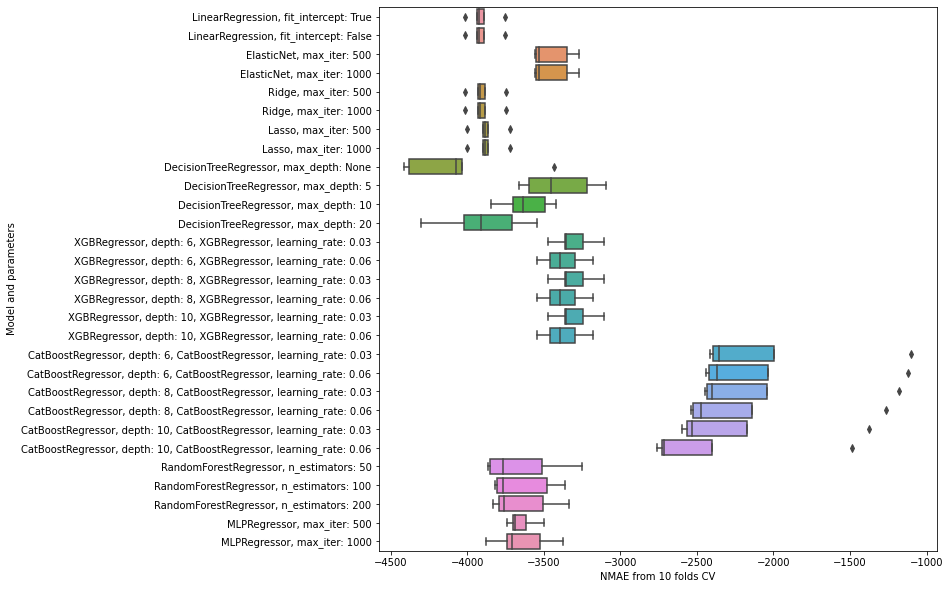

In [ ]:
plt.figure(figsize=(10,10))
results = pd.read_csv('exp.csv', na_filter=False)

ax = sns.boxplot(data=results, y="parameters", x="score", orient="h")
ax.set(xlabel='NMAE from 10 folds CV', ylabel='Model and parameters')
plt.show()

## First model - DecisionTreeRegressor

Based on the above test, the first choosen model was the decision tree. 

It was chosen because:
* it achieved high score in the pre-elimination test - the result matches much more advanced algorithms
* very high interpretability and explainability, perfect for visual representation
* closely mimics the human decision-making process
* fast inference
* feature selection happens automatically: unimportant features will not influence the result

Possible risks:
* high potential to overfitting
* inadequate for predicting continuous values.

In [ ]:
df = pd.read_csv('final_df.csv', na_filter=False)

X = df.drop(['score'], axis=1)
y = df['score']

models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
}

params = {
    'DecisionTreeRegressor': {
        'model__max_depth': [1, 2, 3, 4, 5, 10],
        'model__criterion': ["mse", "friedman_mse", "mae"],
        'model__splitter': ["best", "random"],
        'model__max_features': ["auto", "sqrt", "log2", None],
    }
}

results = pd.DataFrame()

cv = 5

for model_name in models:
    print(model_name)

    transformer = RobustScaler()
    pipeline = Pipeline([('transformer', transformer), ('model', models[model_name])])

    gs = GridSearchCV(pipeline, params[model_name], cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1,
                      refit=False)
    gs.fit(X, y)

    result = pd.DataFrame.from_dict(gs.cv_results_)

    result['model'] = model_name
    result = result.melt(id_vars=["model", "params"], value_vars=[f"split{num}_test_score" for num in range(cv)],
                         var_name="test_id", value_name="score")
    result['parameters'] = result['params'].apply(lambda x: "{}, {}".format(model_name, ", ".join(
        ["{}: {}".format(key.replace("model__", ""), value) for key, value in x.items()])))

    results = results.append(result, sort=False)
    results.to_csv("exp_decision_tree.csv", index=False)


DecisionTreeRegressor
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 81.3min finished


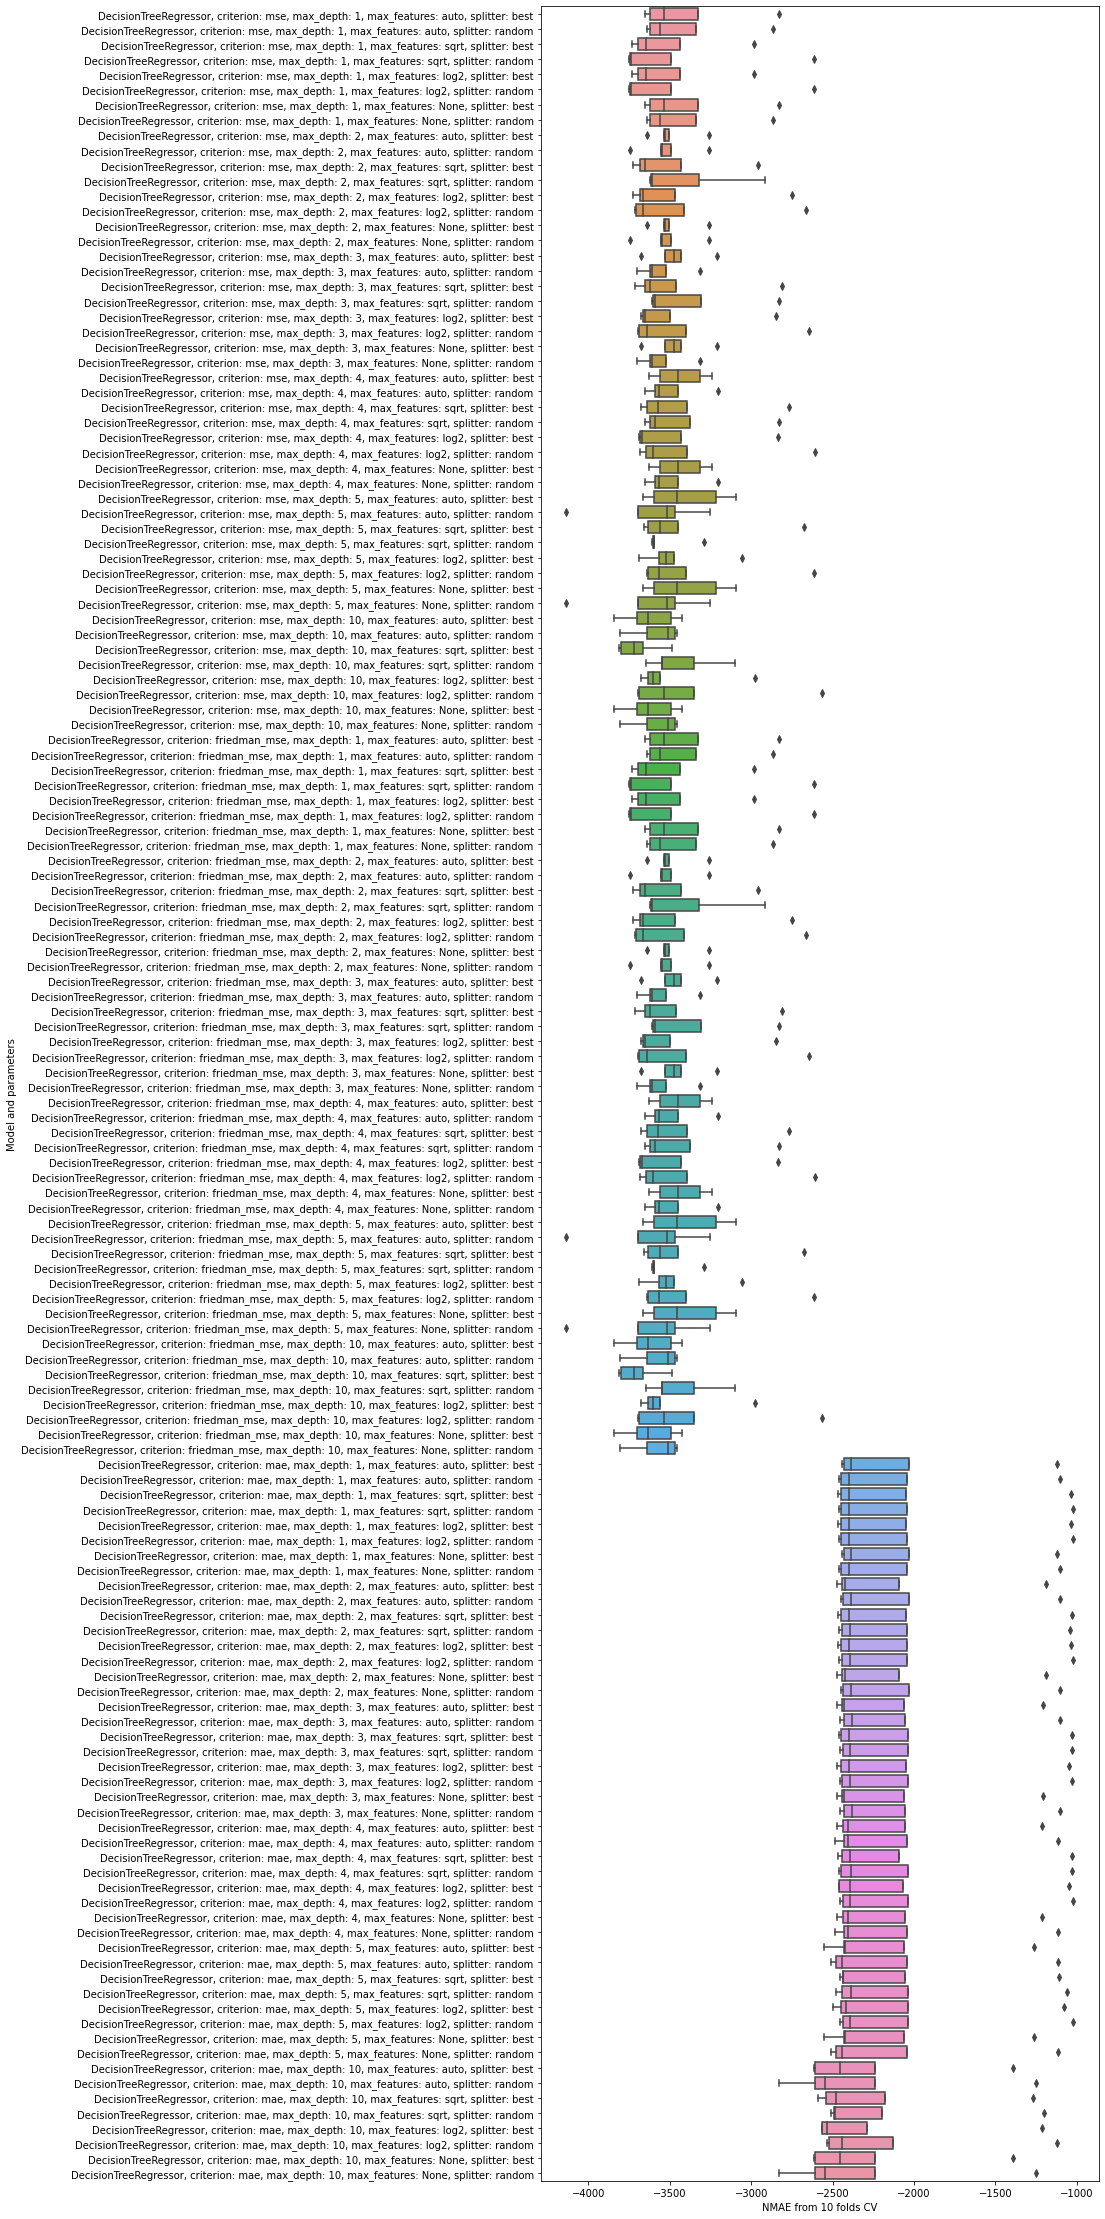

In [ ]:
plt.figure(figsize=(10,40))
results = pd.read_csv('exp_decision_tree.csv', na_filter=False)

ax = sns.boxplot(data=results, y="parameters", x="score", orient="h")
ax.set(xlabel='NMAE from 10 folds CV', ylabel='Model and parameters')
plt.show()

In [ ]:
results.groupby('parameters').median().nlargest(20, columns='score')

score
parameters                                                     
DecisionTreeRegressor, criterion: mae, max_dept... -2379.879217
DecisionTreeRegressor, criterion: mae, max_dept... -2379.879217
DecisionTreeRegressor, criterion: mae, max_dept... -2384.375483
DecisionTreeRegressor, criterion: mae, max_dept... -2384.375483
DecisionTreeRegressor, criterion: mae, max_dept... -2384.812774
DecisionTreeRegressor, criterion: mae, max_dept... -2384.812774
DecisionTreeRegressor, criterion: mae, max_dept... -2388.816894
DecisionTreeRegressor, criterion: mae, max_dept... -2389.454417
DecisionTreeRegressor, criterion: mae, max_dept... -2391.846382
DecisionTreeRegressor, criterion: mae, max_dept... -2392.573912
DecisionTreeRegressor, criterion: mae, max_dept... -2393.033737
DecisionTreeRegressor, criterion: mae, max_dept... -2393.201133
DecisionTreeRegressor, criterion: mae, max_dept... -2393.743626
DecisionTreeRegressor, criterion: mae, max_dept... -2393.856554
DecisionTreeRegressor, criterion: mae, max_dept... -2394.791141
DecisionTreeRegressor, criterion: mae, max_dept... -2395.956091
DecisionTreeRegressor, criterion: mae, max_dept... -2397.354365
DecisionTreeRegressor, criterion: mae, max_dept... -2398.404584
DecisionTreeRegressor, criterion: mae, max_dept... -2398.404584
DecisionTreeRegressor, criterion: mae, max_dept... -2398.404584

In [ ]:
df = pd.read_csv('final_df.csv', na_filter=False)

X = df.drop(['score'], axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = DecisionTreeRegressor(criterion='mae', max_depth=5, max_features='log2', splitter='random', random_state=0)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mean_absolute_error(y_true=y_test,y_pred=y_pred)

2040.188771568375

In [ ]:
for truth, pred_sample in list(zip(y_test, y_pred))[0:25]:
  print(truth, " ", int(pred_sample))

1408   122
32   30
1197   889
1300   110
9   33
21   202
90   202
27   30
170   110
482   202
2519   254
105   73
361   79
50   361
0   30
74   110
606   202
269   202
456   202
43   202
20   73
81   202
552   30
0   30
236   30


True

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127765 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127996 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127765 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128588 missing from current font.
  font.

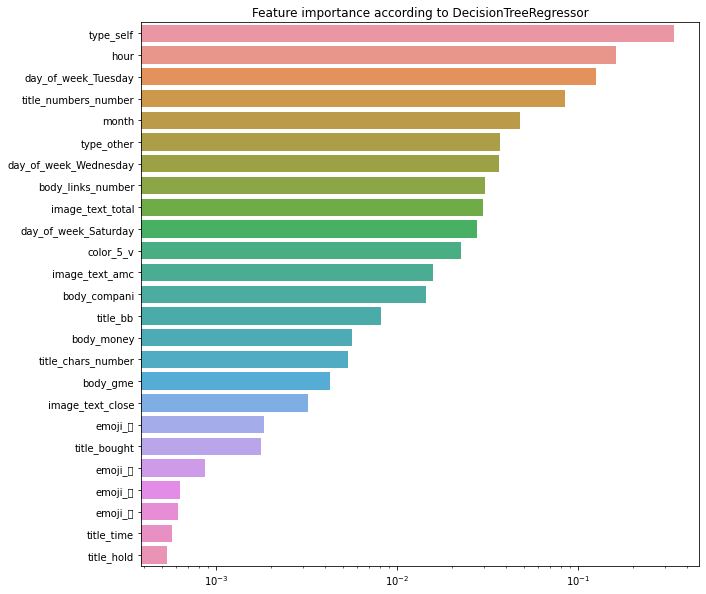

In [ ]:
n_largest = 25

plt.figure(figsize=(10,10))

dtr_importance = pd.Series(model.feature_importances_, index=X.columns)

head = dtr_importance.nlargest(n_largest)
ax = sns.barplot(x=head.values, y=head.index)
ax.set_title("Feature importance according to DecisionTreeRegressor")
ax.set_xscale("log")

True

Rules used to predict sample 1:

decision node 0 : (X_test[1, type_self] = 0) <= 0.5814402962948383)
decision node 1 : (X_test[1, day_of_week_Tuesday] = 0) <= 0.7605316572638842)
decision node 2 : (X_test[1, day_of_week_Saturday] = 0) <= 0.5206412819775945)
decision node 3 : (X_test[1, image_text_total] = 0.22698364448814384) > 0.15573737824137202)
decision node 7 : (X_test[1, emoji_🏼] = 0.0) <= 0.6191037420564552)



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127996 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0.0, flags=flags)


True

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127996 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0, flags=flags)


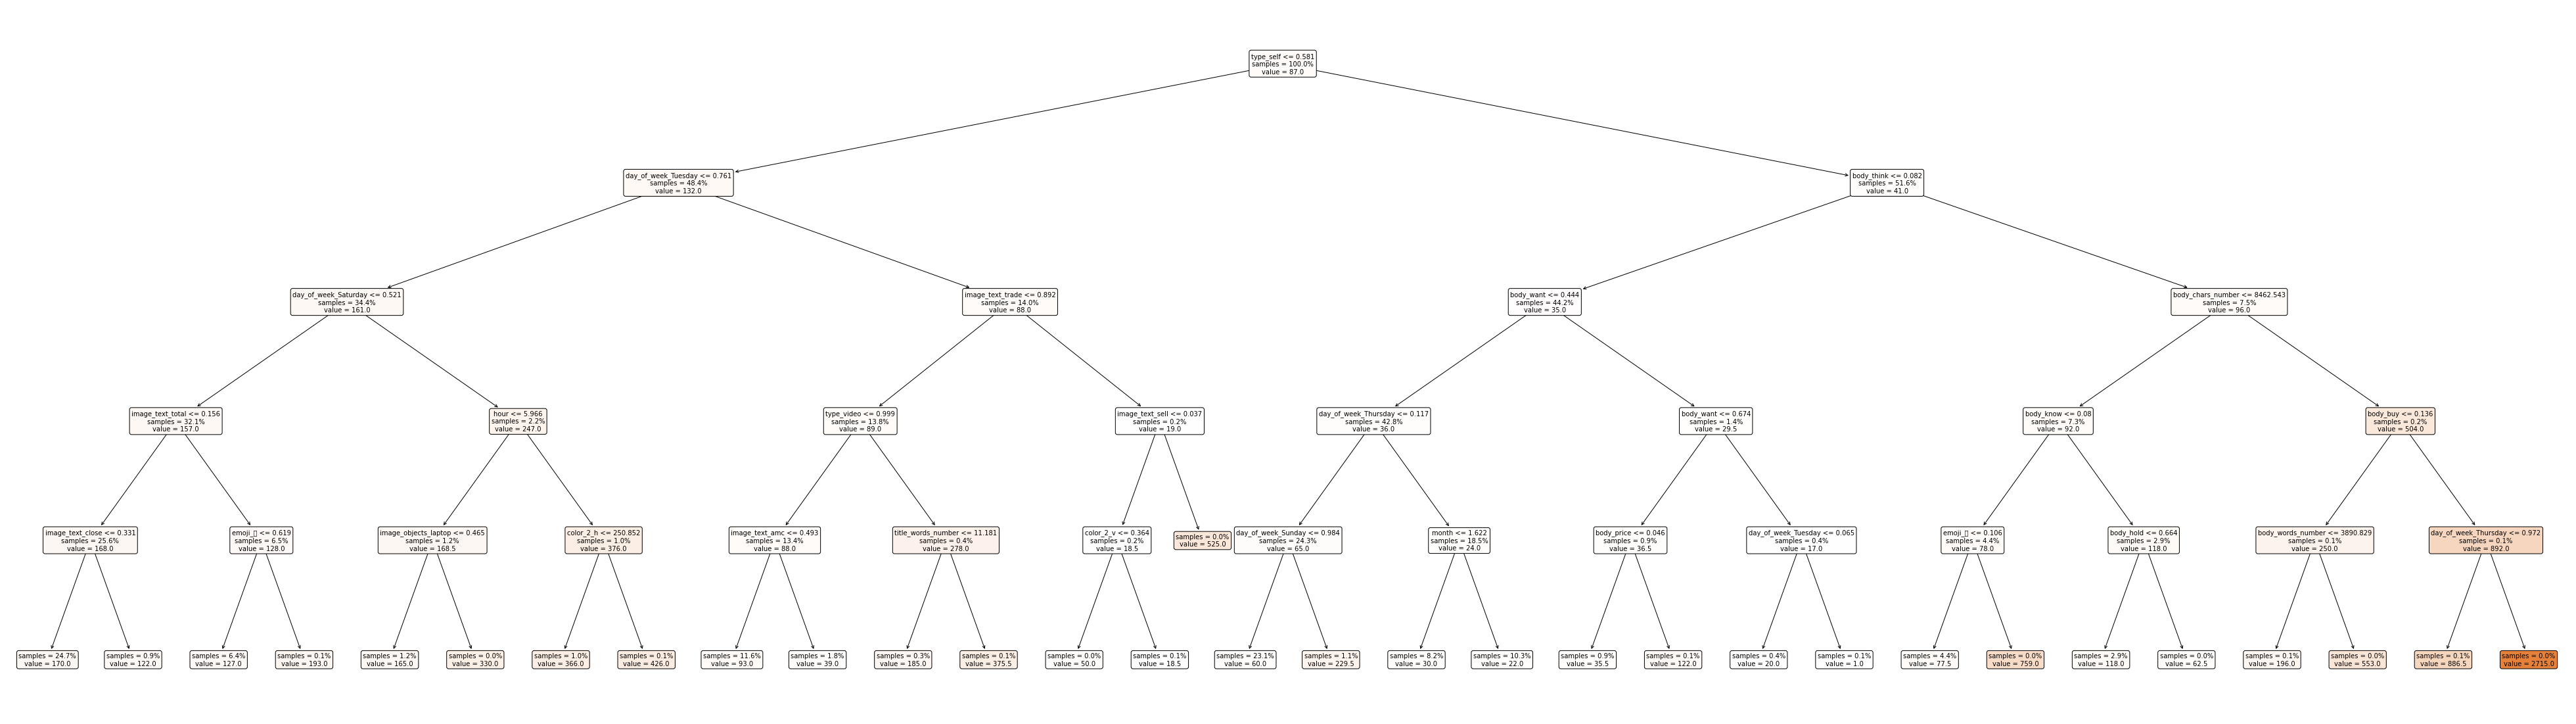

In [ ]:
n_nodes = model.tree_.node_count
children_left = model.tree_.children_left
children_right = model.tree_.children_right
feature = model.tree_.feature
threshold = model.tree_.threshold

node_indicator = model.decision_path(X_test)
leaf_id = model.apply(X_test)

sample_id = 1
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

feature_names = X.columns

print('Rules used to predict sample {id}:\n'.format(id=sample_id))
for node_id in node_index:
    if leaf_id[sample_id] == node_id:
        continue

    if (X_test.iloc[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision node {node} : (X_test[{sample}, {feature}] = {value}) "
          "{inequality} {threshold})".format(
              node=node_id,
              sample=sample_id,
              feature=feature_names[feature[node_id]],
              value=X_test.iloc[sample_id, feature[node_id]],
              inequality=threshold_sign,
              threshold=threshold[node_id]))
    
print("")
plt.figure(figsize=(70,20))

plot_tree(model, 
          feature_names = feature_names, 
          filled = True, 
          max_depth = 8,
          impurity = False,
          proportion=True,
          fontsize=10,
          rounded = True)

True

## Second model - CatBoost
The second algorithm choosen is the `CatBoostRegressor` algorithm which is an algorithm for gradient boosting on decision trees. It was chosen because:
* very high interpretability and explainability
* algorithm was/is used by influential companies (CERN, CLoudflare, Yandex) and it's library is well documented and maintained
* requires very little parameter tuning
* used for example in search engines (one-hot encoding) and for weather prediction (continuous, numerical attributes)

In [ ]:
df = pd.read_csv('final_df.csv', na_filter=False)

X = df.drop(['score'], axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = CatBoostRegressor(loss_function='MAE', early_stopping_rounds=10, silent=True)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

mean_absolute_error(y_true=y_test,y_pred=y_pred)

2008.1155938271672

In [ ]:
for truth, pred_sample in list(zip(y_test, y_pred))[0:25]:
  print(truth, " ", int(pred_sample))

1408   244
32   17
1197   569
1300   120
9   37
21   15
90   123
27   35
170   159
482   403
2519   486
105   68
361   99
50   140
0   3
74   122
606   231
269   513
456   2285
43   46
20   14
81   110
552   67
0   259
236   143


### Individual predictions explained via LIME

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names=X_train.columns.to_list(), mode='regression')


In [ ]:
# Rather accurate prediction
print(f"Actual value: {y_test.iloc[8]}")
exp = explainer.explain_instance(X_test.iloc[8].to_numpy(), model.predict, num_features=35)
exp.show_in_notebook(show_table=True)

Actual value: 252


In [ ]:
# Unpopular prediction
print(f"Actual value: {y_test.iloc[50]}")
exp = explainer.explain_instance(X_test.iloc[50].to_numpy(), model.predict, num_features=35)
exp.show_in_notebook(show_table=True)

Actual value: 1


In [ ]:
# # Popular prediction
print(f"Actual value: {y_test.iloc[49]}")
exp = explainer.explain_instance(X_test.iloc[49].to_numpy(), model.predict, num_features=35)
exp.show_in_notebook(show_table=True)

Actual value: 99719


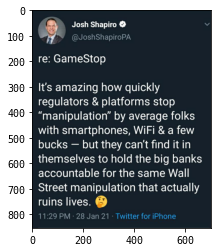

In [ ]:
import matplotlib.image as mpimg

image_data =  pd.read_csv('with_image_text_attributes.csv', na_filter=False)
# list(image_data.iloc[22034])
plt.imshow(mpimg.imread("./images/l7b321.jpg"))

# Wysoka cena GameStop, obrazek zawiera "person" oraz "tie"

### Counterexample - Relatively good score, but very limited information

In [ ]:
print(f"Actual value: {y_test.iloc[117]}")
exp = explainer.explain_instance(X_test.iloc[117].to_numpy(), model.predict, num_features=35)
exp.show_in_notebook(show_table=True)

Actual value: 781


### Feature importance

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128640 missing from current font.
  font.set_text(s, 0, flags=flags)


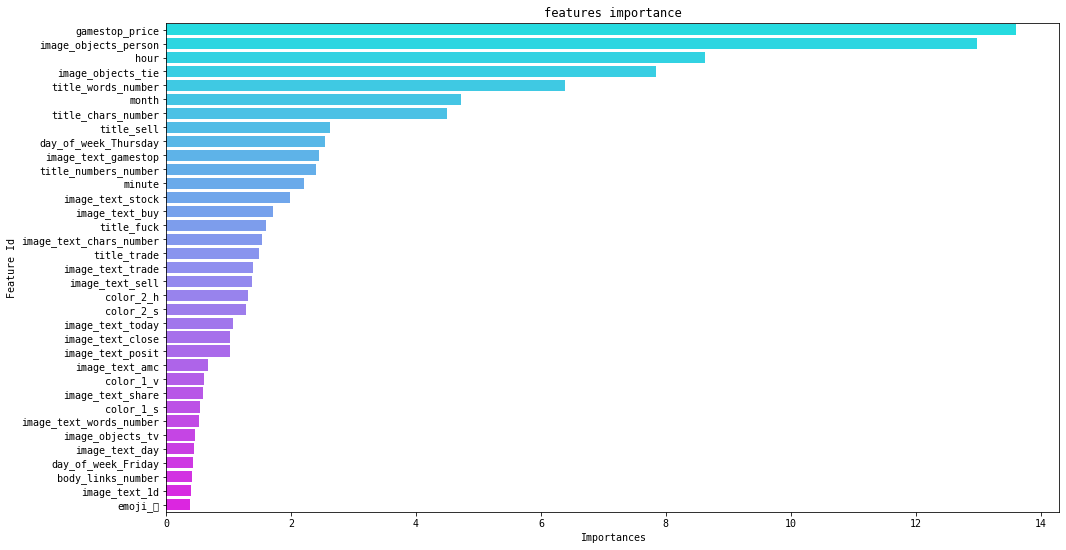

In [ ]:
 import matplotlib.pyplot as plt
 plt.rcParams["font.family"] = "monospace"

df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True)[0:35])

# 🚀

plt.figure(figsize=(16, 9));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool");
plt.title('features importance');

## Explanation

* Include image OR video (however, the video wasn't thoroughly checked, the ones dataset has just so happen to rank well)
* Include a person with a tie in your image
* Post at times US citizens are browsing memes
* Higher GameStop price makes everyone more excited and more ready to like your post
* Include words such as "sell", "today", "let", "bb", "trade", "guy", "robinhood" in the title, as reference see existing posts with these words
* Be in favor of GameStop Stock price rising, as indicated by 🚀 emoji
* Good to use emojis are: 🚀, _🏻, _🏼, 💎, 🌙
* Thursday or Friday are the best days to post on
* Don't include airplanes, clocks, refrigators or cells in your image
* Don't use 🌕, 📈 emoji


## Others

In [ ]:
df = pd.read_csv('final_df.csv', na_filter=False)

X = df.drop(['score'], axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = DecisionTreeRegressor(criterion='mae', max_depth=5, max_features='log2', splitter='random', random_state=0)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)

print("Entire dataset")
print(f"Dataset length {len(df)}, Score: Max: {df.score.max()}, Median: {df.score.median()}, Mean: {df.score.mean()}")
print(f"MAE: {mae}")

df = df[df.score < df.score.quantile(.95)]

X = df.drop(['score'], axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = DecisionTreeRegressor(criterion='mae', max_depth=5, max_features='log2', splitter='random', random_state=0)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)

print("\n95th score percentile")
print(f"Dataset length {len(df)}, Score: Max: {df.score.max()}, Median: {df.score.median()}, Mean: {df.score.mean()}")
print(f"MAE: {mae}")

Entire dataset
Dataset length 19413, Score: Max: 403161, Median: 99.0, Mean: 2107.0387884407355
MAE: 2040.188771568375

95th score percentile
Dataset length 18442, Score: Max: 6799, Median: 86.0, Mean: 324.64835701117016
MAE: 289.9514773651396
